# Simulation Results

This notebook creates graphs for simulation results.

In [1]:
import os

# Workaround for using the Jupyter container from VS Code Jupyter extension.
if not os.path.exists('./simulation-scenarios'):
    os.chdir('./chunk-func/jupyter')

In [2]:
from dataclasses import dataclass
import math
import pandas as pd
from pandas.core.groupby.generic import DataFrameGroupBy

# Definitions of our column names.
col_strategy = 'strategy'
col_slo = 'sloMs'
col_input_size = 'scenario'
col_response_time = 'executionTimeMs'
col_cost = 'cost'
col_alg_exec_time = 'avgResConfigStratExecTimeMs'
col_workflow = 'Workflow' # Only used in output DataFrames
col_order = 'order' # Used for ordering strategies in cost plots

slo_pseudostrategy = 'SLO'
'''Name of the pseudostrategy used to add rows for the SLO values.'''

chunkfunc_oracle_strategy = 'CF-Oracle'
'''Name of the strategy that knows all function output sizes when computing the critical path.'''

# Display SLO and response time in ms
# response_time_divisor = 1
# response_time_unit = 'ms'

# Display SLO and response time in seconds
# To achieve this we transform the col_slo and col_response_time values in the original DataFrame,
# but the column names remain the same (e.g., sloMs).
response_time_divisor = 1000.0
response_time_unit = 's'

cost_unit = '$'

cost_multiplier = 10000

@dataclass
class WorkflowDescription:
    name: str
    '''The name of the workflow'''
    
    dir: str
    '''The folder, where the results are stored.'''


@dataclass
class SimulationResults(WorkflowDescription):
    df_grouped: DataFrameGroupBy
    '''The simulation results grouped by col_input_size.'''

    df: pd.DataFrame
    '''Time ungrouped simulation results.'''


def load_results(workflow: WorkflowDescription, csv_filename: str, strategies: dict[str, str], strategies_order: dict[str, int], slo_type: str) -> SimulationResults:
    '''Loads the CSV file and groups the DataFrame by the col_input_size'''
    df: pd.DataFrame = pd.read_csv(f'{workflow.dir}/{csv_filename}')

    # Apply transformations and grouping.
    df[col_cost] = df[col_cost].apply(lambda cost: cost * cost_multiplier)
    if slo_type == 'MaxCost':
        df[col_slo] = df[col_slo].apply(lambda cost: cost * cost_multiplier)
    strategy_criterion = df[col_strategy].map(lambda strat: strategies.get(strat, None) is not None)
    df = df[strategy_criterion]
    df[col_strategy] = df[col_strategy].apply(lambda strat: strategies[strat])
    if response_time_divisor > 1:
        df[col_slo] = df[col_slo].apply(lambda slo: slo / response_time_divisor)
        df[col_response_time] = df[col_response_time].apply(lambda resp: resp / response_time_divisor)
    df = df.assign(order=df[col_strategy])
    df[col_order] = df[col_order].apply(lambda strat: strategies_order[strat])
    df_grouped = df.groupby(col_input_size)

    return SimulationResults(name=workflow.name, dir=workflow.dir, df_grouped=df_grouped, df=df)


def load_multiple_results(workflows: list[WorkflowDescription], csv_filename: str, strategies: dict[str, str], strategies_order: dict[str, int], slo_type: str) -> list[SimulationResults]:
    ret = [ load_results(wf, csv_filename, strategies, strategies_order, slo_type) for wf in workflows ]
    return ret


In [3]:
# The strategies that we want to analyze.
# The keys are the names that appear in the CSV files, the values are the names that
# should appear in the graphs and results.
strategies = {
    'ProportionalCriticalPathSlo': 'ChunkFunc',
    'FixedOutputProportionalCPSlo': 'CF-Oracle',
    'Slam': 'SLAM',
    'StepConf': 'StepConf',
}

focus_strategy = 'ChunkFunc'

# Determines the order of the strategies in the cost plots.
strategies_order = {
    'SLAM': 0,
    'ChunkFunc': 1,
    'CF-Oracle': 2,
    'StepConf': 3,
}

workflows: list[WorkflowDescription] = [
    WorkflowDescription(name='Cyclic', dir='./simulation-scenarios/cyclic-workflow'),
    WorkflowDescription(name='FaceDet', dir='./simulation-scenarios/face-detection'),
    WorkflowDescription(name='High Resources - Low Resources', dir='./simulation-scenarios/highres-lowres-workflow'),
    WorkflowDescription(name='Homogeneous', dir='./simulation-scenarios/homogeneous-workflow'),
    # WorkflowDescription(name='LogPro', dir='./simulation-scenarios/log-processing'),
    WorkflowDescription(name='Low Resources - High Resources', dir='./simulation-scenarios/lowres-highres-workflow'),
    WorkflowDescription(name='Random', dir='./simulation-scenarios/random-workflow'),
    WorkflowDescription(name='Staircase', dir='./simulation-scenarios/staircase-workflow'),
    WorkflowDescription(name='VidPro', dir='./simulation-scenarios/video-processing'),

    # Short Workflows
    # WorkflowDescription(name='Short Cyclic', dir='./simulation-scenarios/short-cyclic-workflow'),
    # WorkflowDescription(name='Short Homogeneous', dir='./simulation-scenarios/short-homogeneous-workflow'),
    # WorkflowDescription(name='Short-Long Random', dir='./simulation-scenarios/short-long-random-workflow'),
    # WorkflowDescription(name='Short Staircase', dir='./simulation-scenarios/short-staircase-workflow'),
]

slo_type = 'MaxExecutionTime' # 'MaxExecutionTime' or 'MaxCost'
res_profiles_type = 'aws-bo' # 'gcf', 'aws', or 'aws-bo'

results_filename = f'simulation-results-{res_profiles_type}-{slo_type}.csv'
output_folder = f'./output/{res_profiles_type}/{slo_type}SLO'

simulation_results = load_multiple_results(workflows, results_filename, strategies, strategies_order, slo_type)

In [4]:
def get_slo_metric_column() -> str:
    if slo_type == 'MaxExecutionTime':
        return col_response_time
    elif slo_type == 'MaxCost':
        return col_cost
    else:
        raise ValueError(f'Unknown value for slo_type: {slo_type}')

def get_slo_unit() -> str:
    if slo_type == 'MaxExecutionTime':
        return response_time_unit
    elif slo_type == 'MaxCost':
        return f'{cost_unit} per 10,000 invocations'
    else:
        raise ValueError(f'Unknown value for slo_type: {slo_type}')

In [5]:
# Functions for reshaping DataFrames for plotting SLO compliance.

def pivot_slo_compliance(df: pd.DataFrame) -> pd.DataFrame:
    '''Creates a pivot data frame with the columns ['sloMs', 'strategyA', 'strategyB', ...]'''
    return df.pivot(index=col_slo, columns=col_strategy, values=col_response_time)

def add_slo_as_strategy(df: pd.DataFrame) -> pd.DataFrame:
    '''Adds a pseudostrategy called SLO with the response time set to the SLO value.'''
    strat_a: str
    for key, value in strategies.items():
        # Get the name of any strategy, it doesn't matter which one,
        # because the SLO values are the same for all.
        strat_a = value
        break
    
    slo_rows: pd.DataFrame = df[df[col_strategy] == strat_a].copy(deep=True)
    slo_rows[col_strategy] = slo_rows[col_strategy].apply(lambda x: slo_pseudostrategy)
    slo_rows[col_cost] = slo_rows[col_cost].apply(lambda x: -1)
    slo_rows[col_response_time] = slo_rows[col_slo]
    
    return pd.concat([df, slo_rows])


In [6]:
# Functions for reshaping DataFrames for plotting cost.

def compute_step_for_costs(df: pd.DataFrame, values_count: int) -> int:
    for key, strat_name in strategies.items():
        strat_df: pd.DataFrame = df[df[col_strategy] == strat_name]
        if strat_df.iloc[[-1]][col_slo].values[0] >= 1000000:
            values_count -= 2
        step = math.ceil(len(strat_df) / values_count)
        return step

def select_costs_for_plotting(df: pd.DataFrame, values_count: int) -> pd.DataFrame:
    '''
    Selects values_count rows for every strategy for plotting the costs and
    returns them in a DataFrame.
    The selected rows refer to the same SLOs for every strategy.
    '''
    frames: list[pd.DataFrame] = []
    step = compute_step_for_costs(df, values_count)
    for key, strat_name in strategies.items():
        strat_df: pd.DataFrame = df[df[col_strategy] == strat_name]
        strat_df = strat_df.iloc[::step, :].copy(deep=True)
        # Optional: Set costs of non-SLO compliant runs to 0.
        # strat_df[col_cost] = strat_df.apply(lambda row: row[col_cost] if row[col_response_time] <= row[col_slo] else 0, axis=1)
        frames.append(strat_df)
    return pd.concat(frames)

In [7]:
# Init seaborn and set global defaults
import seaborn as sns

sns.set_theme()
sns.set(font_scale=1.2)

# Ensure that all plots use the same color and dashes assignment for the strategies.
palette = sns.color_palette()
palette_dict = {}
dashes_dict = {}
for key, value in strategies.items():
    palette_dict[value] = palette[len(palette_dict)]
    dashes_dict[value] = ''
palette_dict[slo_pseudostrategy] = (0, 0, 0)
dashes_dict[slo_pseudostrategy] = (3, 3)

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LinearLocator

def get_x_bounds(results: pd.DataFrame) -> tuple[int, int]:
    '''Returns the lowest and the largest SLO value for an experiment.'''
    first_strat = results.iloc[[0]][col_strategy].values[0]
    single_strat_df: pd.DataFrame = results[results[col_strategy] == first_strat]
    x_min = single_strat_df.iloc[[0]][col_slo].values[0]
    x_max = single_strat_df.iloc[[-1]][col_slo].values[0]
    return (x_min, x_max)

def create_number_formatter(column: pd.Series, force_no_decimal: bool):
    '''
    Returns a string formatting function that prints 
        - no decimal places if the entire column consists of integers
        - rounded value to no decimal places if the median value is >= 1000 or force_no_decimal is True
        - or one decimal place, otherwise.
    '''
    if column.apply(lambda x: float.is_integer(float(x))).all():
        return lambda x, pos: f'{x:,.0f}'
    median_idx = math.floor(len(column) / 2)
    if force_no_decimal or column.iloc[median_idx] >= 1000:
        return lambda x, pos: f'{round(x, 0):,.0f}'
    return lambda x, pos: f'{x:,.1f}'

def draw_slo_relplot(results: pd.DataFrame, ycol: str) -> sns.FacetGrid:
    '''Draws a relplot using the specified y-column.'''
    x_bounds = get_x_bounds(results)
   
    # Plot the response times.
    g: sns.FacetGrid = sns.relplot(
        data=results,
        kind='line',
        x=col_slo,
        y=ycol,
        hue=col_strategy,
        palette=palette_dict,
        style=col_strategy,
        dashes=dashes_dict,
        height=4,
        aspect=1.875,
        facet_kws=dict(sharex=True, legend_out=False),
    )
    sns.move_legend(g, 'upper left', bbox_to_anchor=(0.15, 0.9))
    g.legend.set_title('')

    # g.set_xticklabels(step=1)
    g.ax.xaxis.set_major_formatter(FuncFormatter(create_number_formatter(results[col_slo], False)))
    g.ax.yaxis.set_major_formatter(FuncFormatter(create_number_formatter(results[ycol], True)))
    g.ax.set_xlim(xmin=x_bounds[0], xmax=x_bounds[1])
    numticks = 9
    if x_bounds[1] >= 1000000:
        numticks = numticks - 1
    g.ax.xaxis.set_major_locator(LinearLocator(numticks=numticks))

    return g


def plot_slo_compliance(results: pd.DataFrame, title: str):
    g = draw_slo_relplot(results, get_slo_metric_column())
    
    # g.ax.set_title(title)
    g.set_axis_labels(f'SLO ({get_slo_unit()})', f'Response Time ({response_time_unit})')
    g.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-slo-compliance.pdf', bbox_inches='tight')
    g.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-slo-compliance.png', bbox_inches='tight')


def plot_alg_exec_time(results: pd.DataFrame, title: str):
    alg_exec_times = results[(results[col_strategy] != slo_pseudostrategy) & (results[col_strategy] != chunkfunc_oracle_strategy)]
    fig = plt.figure(figsize=(8, 3))
    ax = sns.boxplot(
        data=alg_exec_times,
        x=col_strategy,
        y=col_alg_exec_time,
        hue=col_strategy,
        palette=palette_dict,
        fill=False,
    )
    # ax.set_title(title)
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('Heuristic Exec Time (ms)')
    fig.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-alg-exec-time.pdf', bbox_inches='tight')
    fig.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-alg-exec-time.svg', bbox_inches='tight')
    fig.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-alg-exec-time.png', bbox_inches='tight')


def plot_costs(results: pd.DataFrame, title: str):
    fig = plt.figure(figsize=(8, 3))
    sorted_results = results.sort_values([col_slo, col_order])
    ax = sns.barplot(
        data=sorted_results,
        x=col_slo,
        y=col_cost,
        hue=col_strategy,
        palette=palette_dict,
    )
    
    # Add a hatch pattern to bars where the SLO is violated.
    i = 0
    for bar in ax.patches:
        if i >= len(sorted_results):
            break
        if sorted_results[col_response_time].iloc[i] > sorted_results[col_slo].iloc[i]:
            bar.set_hatch('///')
            # bar.set_facecolor('grey')
        i+=1
    
    # ax.set_title(title)
    ax.legend().set_title('')
    ax.xaxis.set_label_text(f'SLO ({response_time_unit})')
    ax.yaxis.set_label_text('Cost ($)')
    slos = sorted_results[col_slo]
    slos = slos[::len(strategies)] # Every SLO is repeated for every strategy, but we only need each SLO once.
    format_slo = create_number_formatter(slos, False)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: format_slo(slos.iloc[pos], pos)))
    ax.yaxis.set_major_formatter(FuncFormatter(create_number_formatter(sorted_results[col_cost], True)))
    fig.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-costs.pdf', bbox_inches='tight')
    fig.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-costs.svg', bbox_inches='tight')
    fig.savefig(f'{output_folder}/{title}-{res_profiles_type}-{slo_type}-costs.png', bbox_inches='tight')

In [9]:
def compute_slo_compliance(results: pd.DataFrame) -> dict[str, float]:
    col_slo_metric = get_slo_metric_column()
    compliances: dict[str, float] = {}
    for strat in strategies.values():
        strat_df = results[results[col_strategy] == strat]
        slo_compliant = strat_df[strat_df[col_slo_metric] <= strat_df[col_slo]]
        total_rows = len(strat_df)
        slo_compliant_rows = len(slo_compliant)
        slo_compliant_percent = slo_compliant_rows / total_rows
        compliances[strat] = slo_compliant_percent
    return compliances


def compute_cost_when_slo_compliant(sim_result: SimulationResults) -> dict[str, float]:
    focus_strat: pd.DataFrame = sim_result.df[sim_result.df[col_strategy] == focus_strategy]
    cost_stats: dict[str, float] = {}
    col_slo_metric = get_slo_metric_column()

    for strat in strategies.values():
        strat_slo_compliant: pd.DataFrame = sim_result.df[(sim_result.df[col_strategy] == strat) & (sim_result.df[col_slo_metric] <= sim_result.df[col_slo])]
        strat_mean_cost = strat_slo_compliant[col_cost].mean()
        cost_stats[strat] = strat_mean_cost

        if strat != focus_strategy:
            slo_values = strat_slo_compliant[col_slo].to_list()
            focus_range = focus_strat.merge(strat_slo_compliant, how='inner', on=[col_slo, col_input_size])
            if len(slo_values) != len(focus_range):
                raise Exception(f'len(slo_values) != len(focus_range): {len(slo_values)} != {len(focus_range)}')
            focus_range_mean_cost = focus_range[f'{col_cost}_x'].mean()
            cost_stats[f'{focus_strategy}/{strat} (both SLO compliant)'] = focus_range_mean_cost / strat_mean_cost


    return cost_stats

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


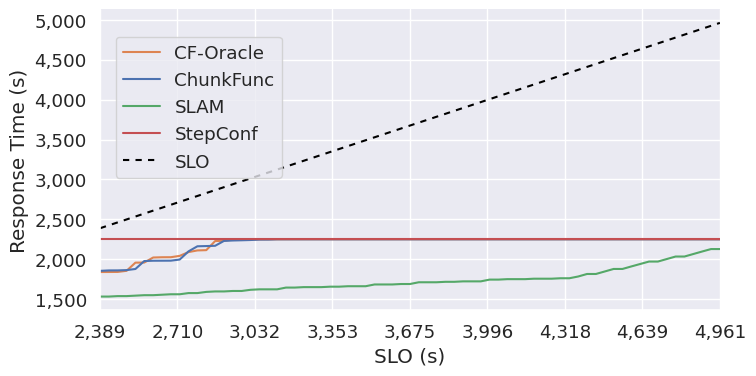

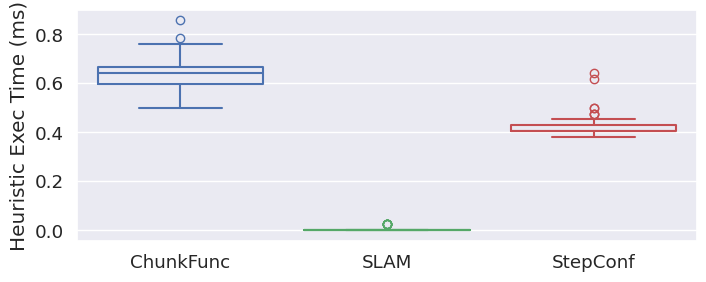

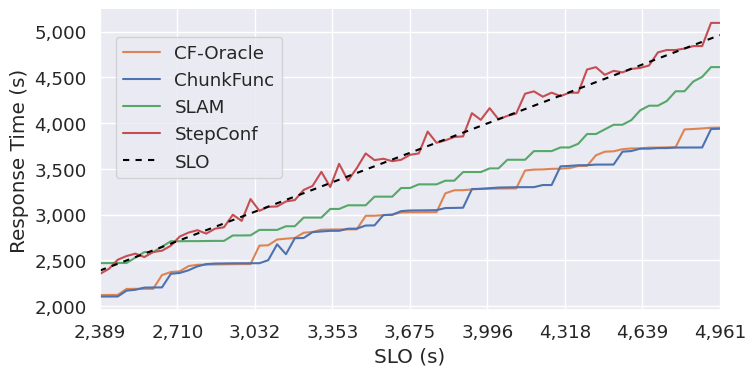

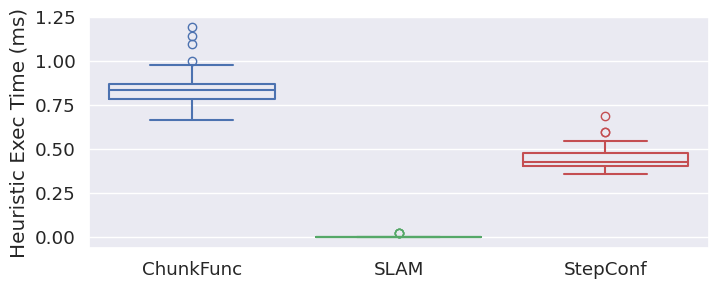

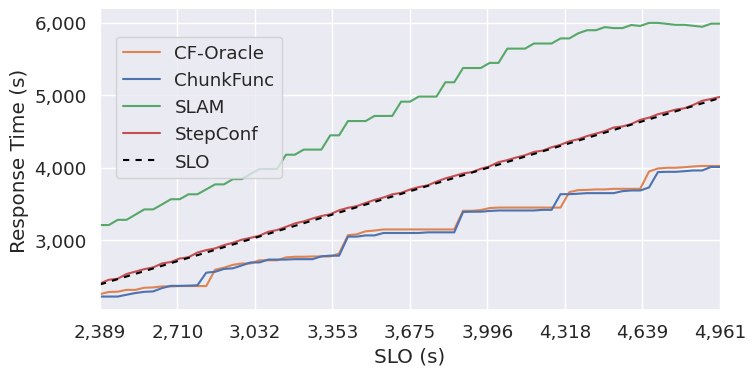

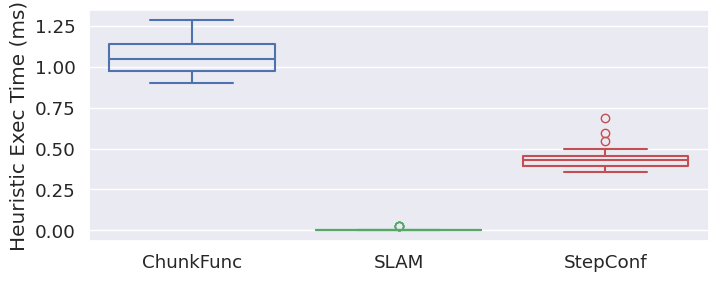

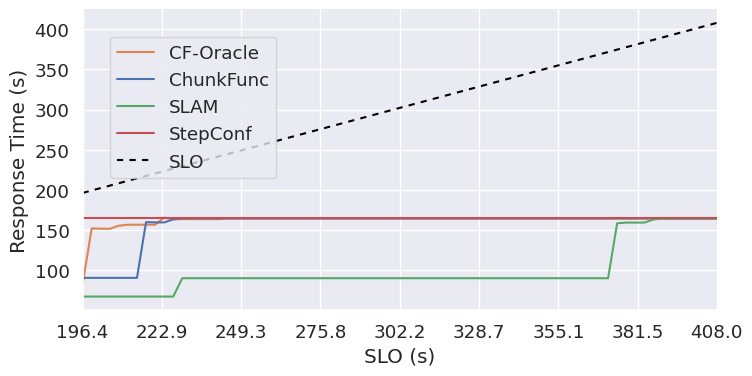

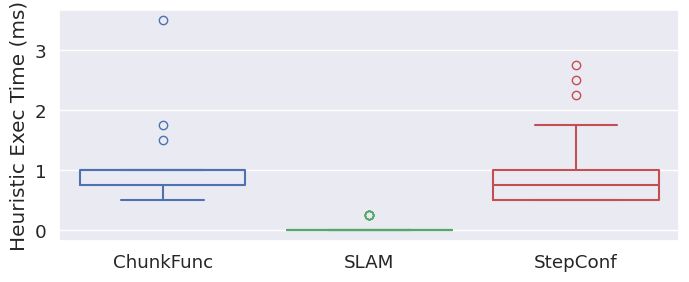

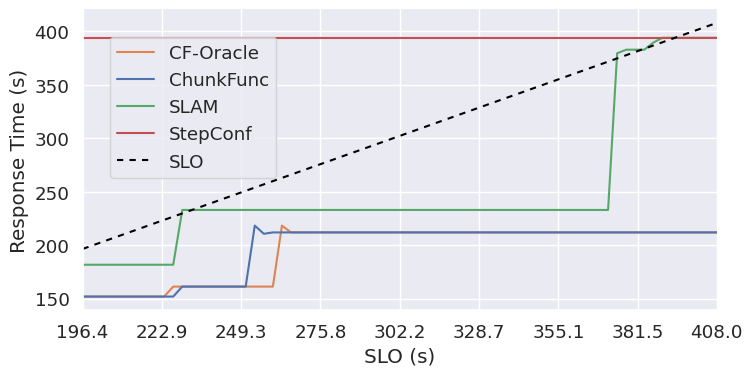

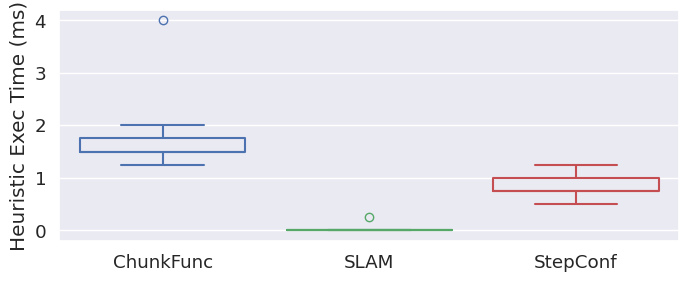

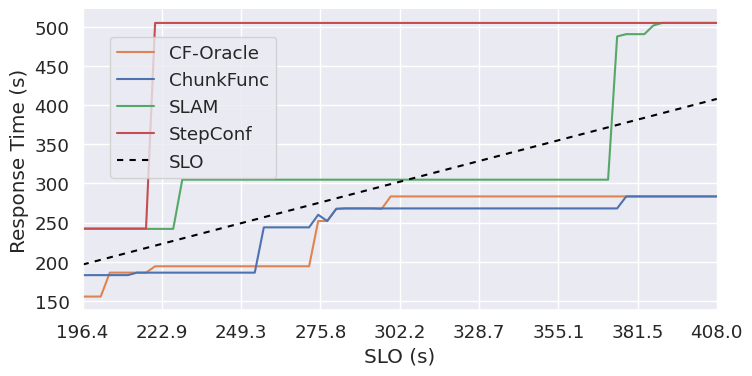

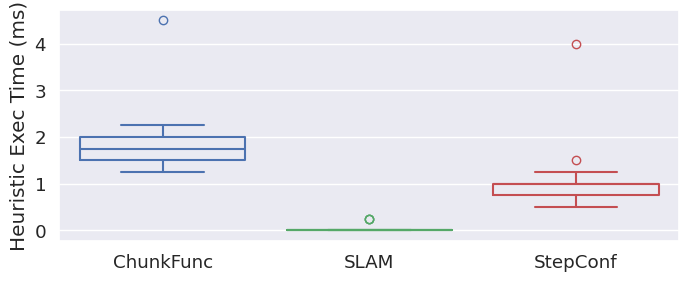

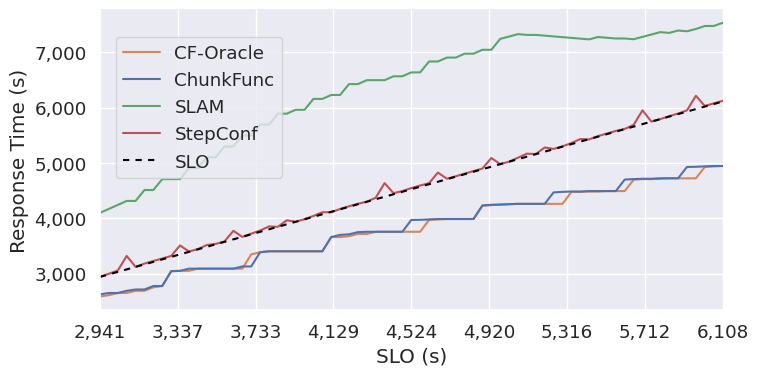

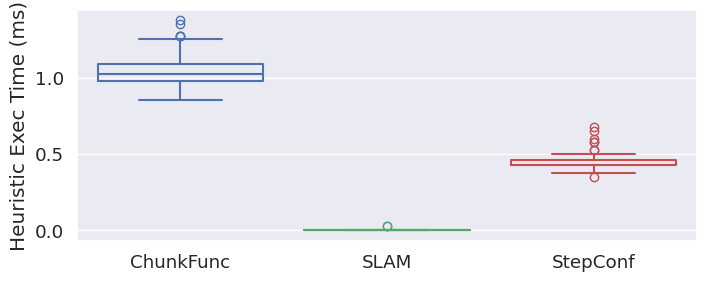

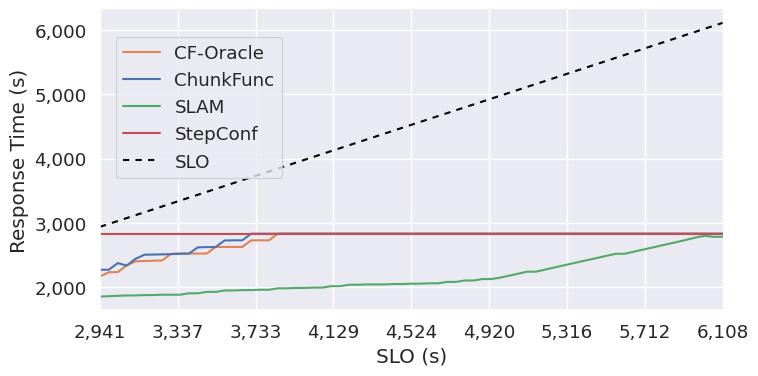

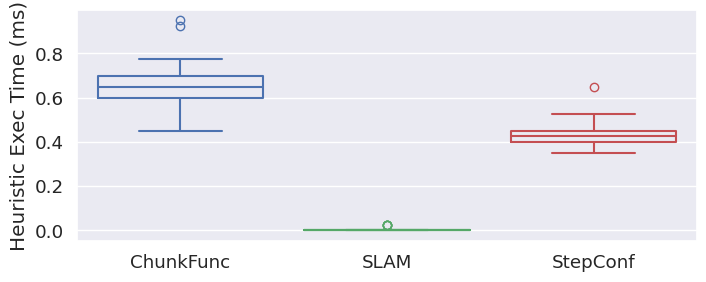

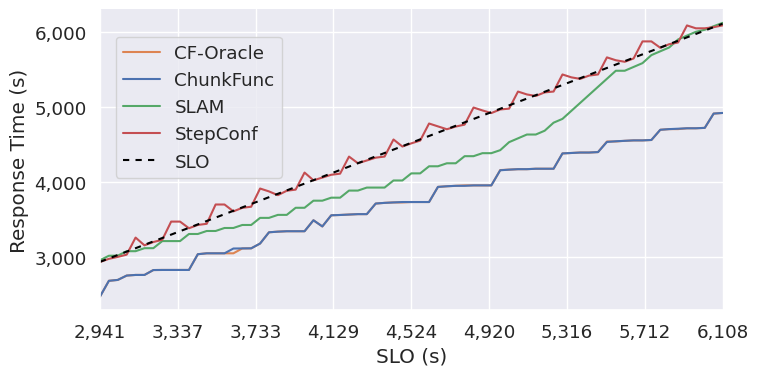

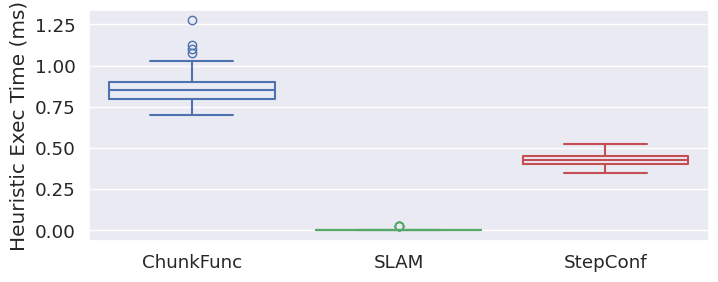

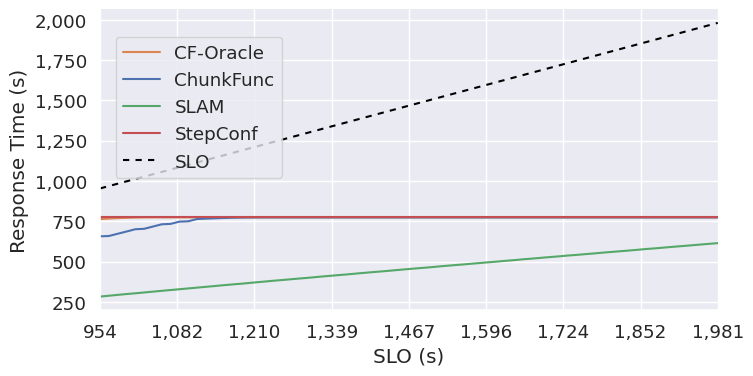

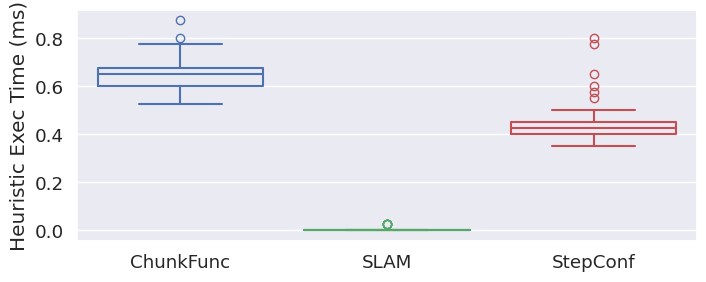

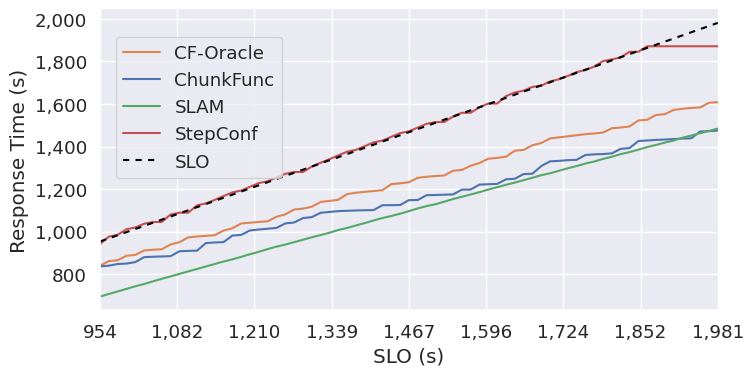

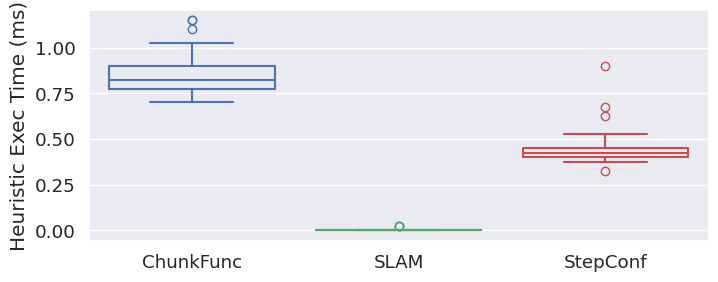

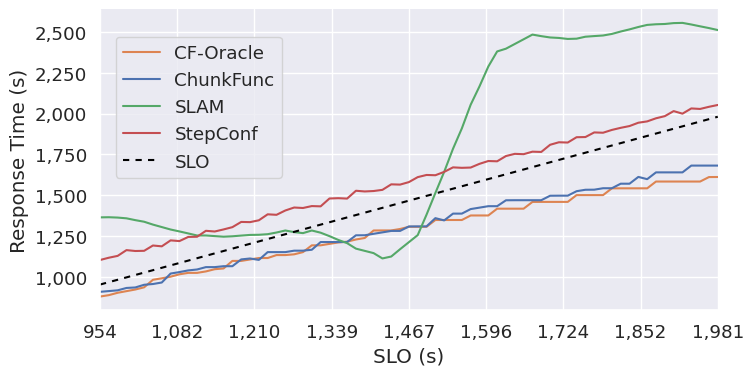

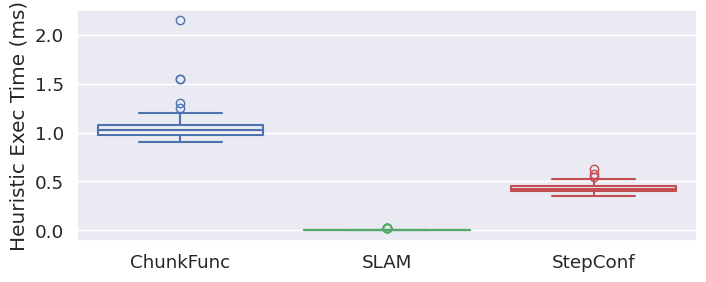

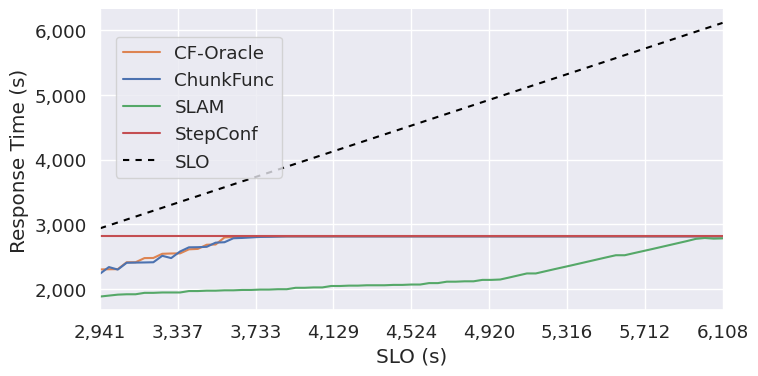

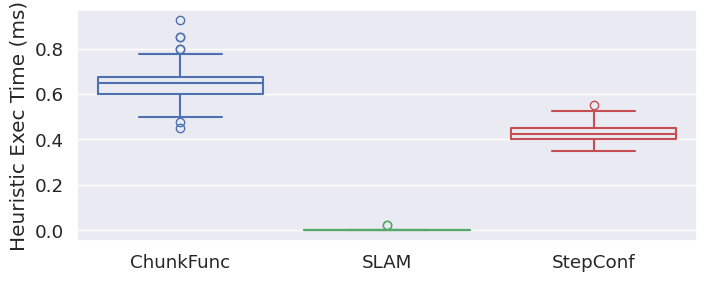

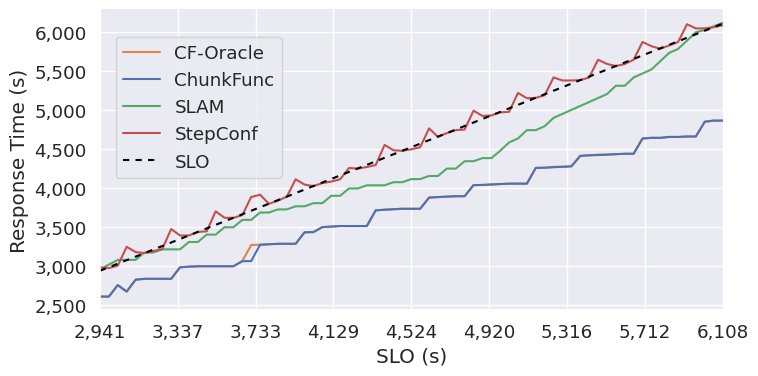

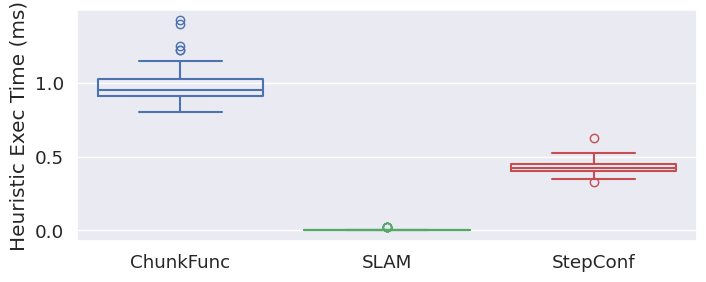

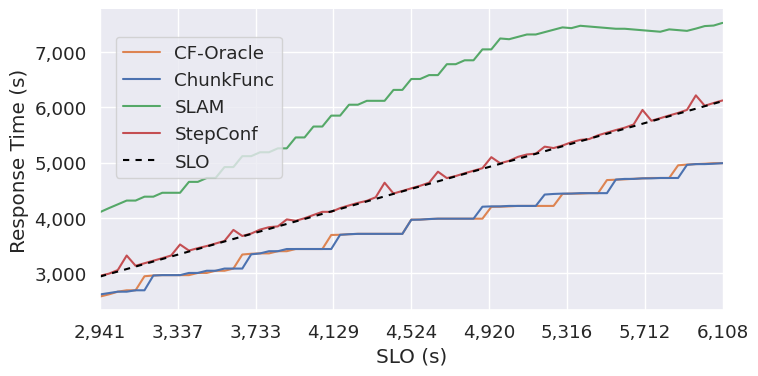

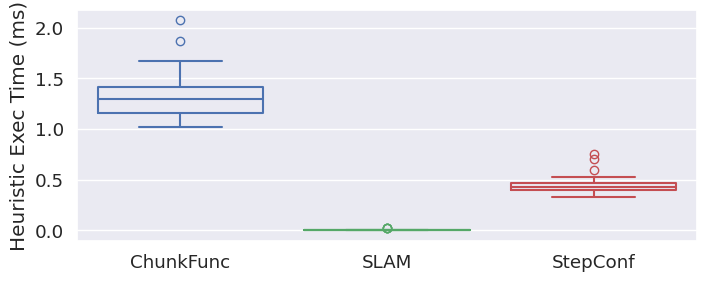

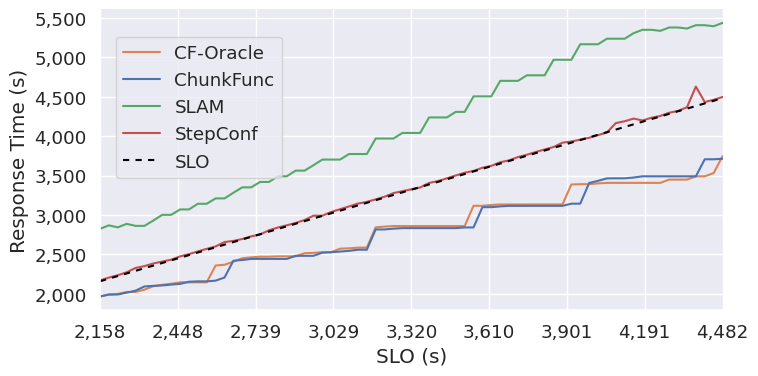

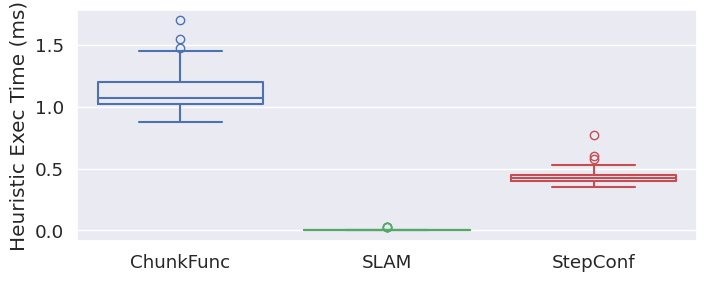

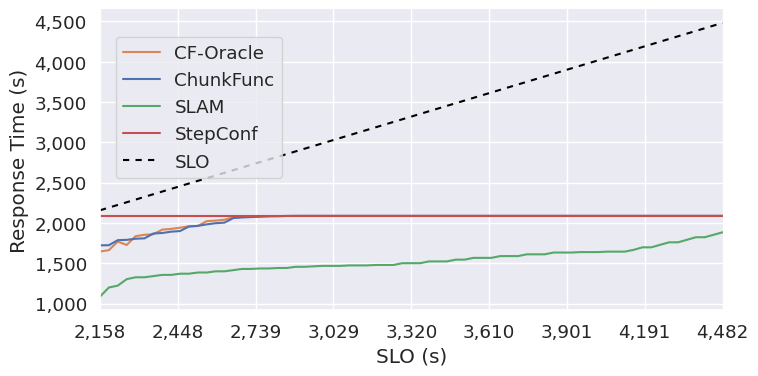

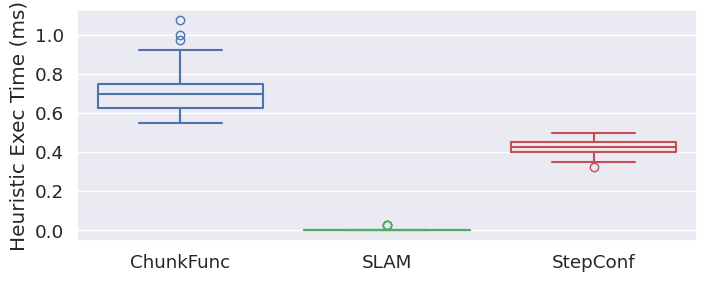

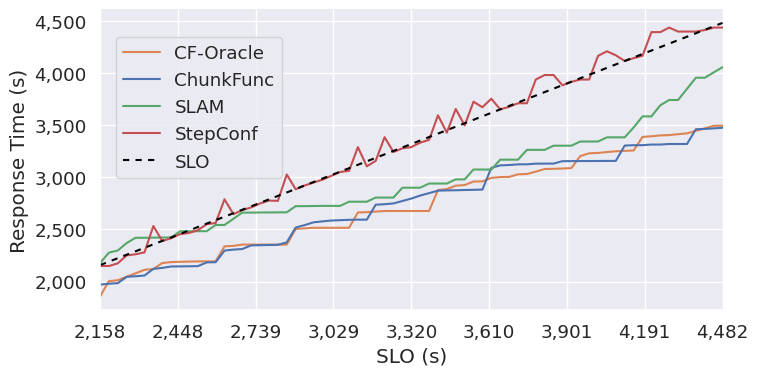

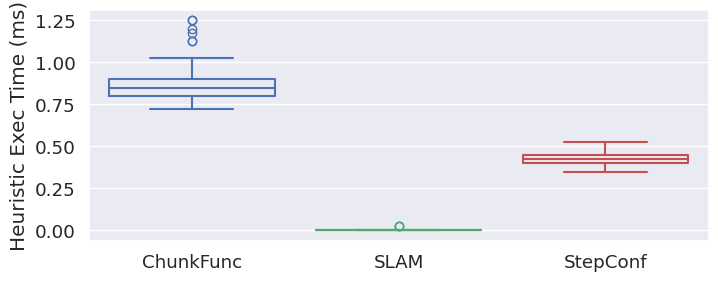

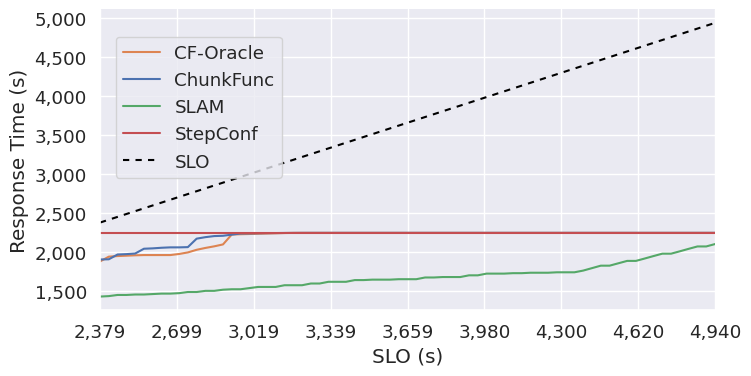

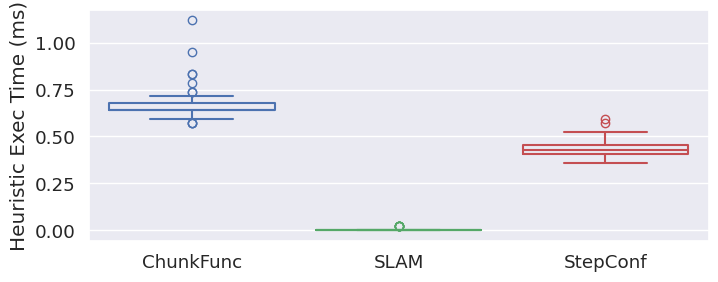

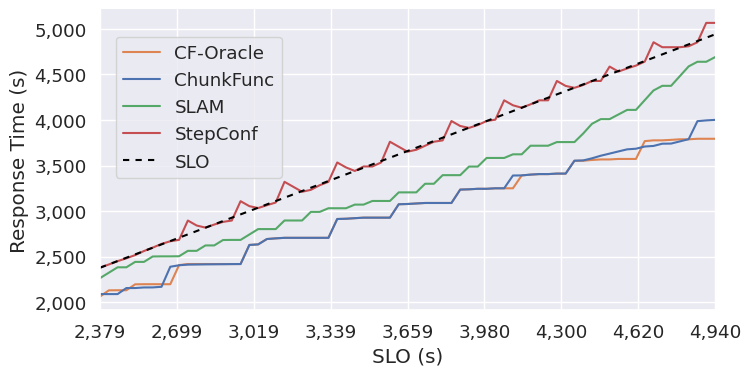

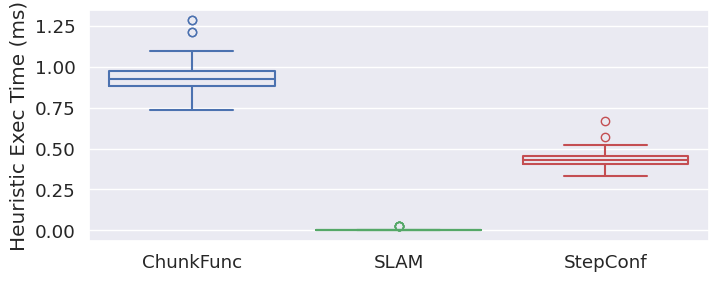

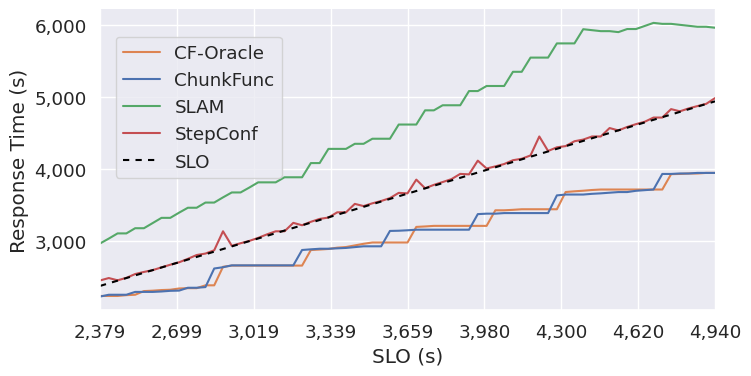

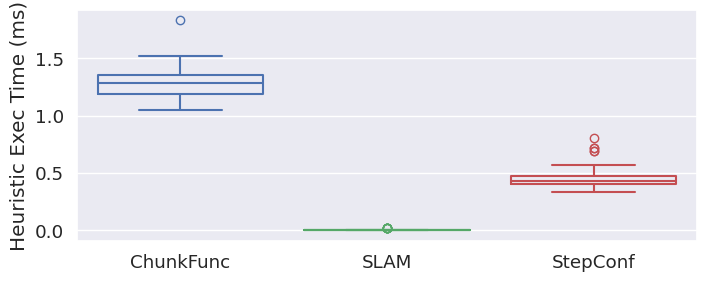

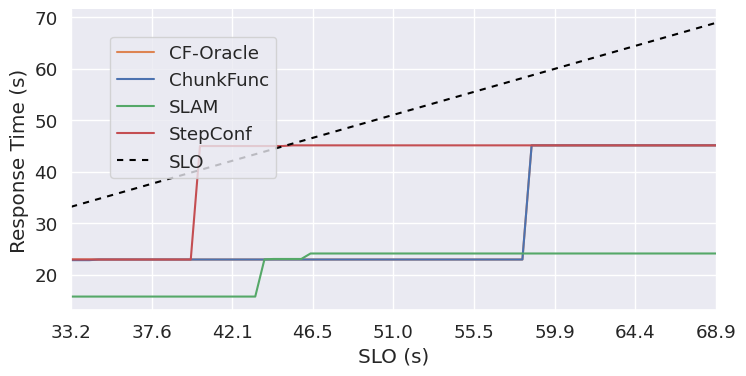

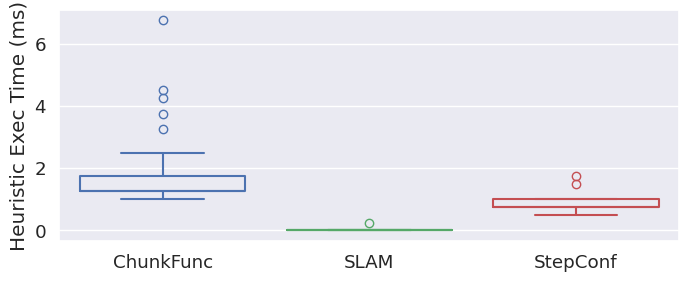

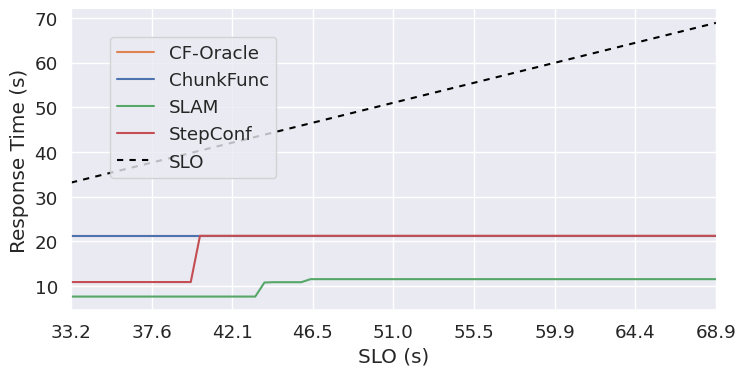

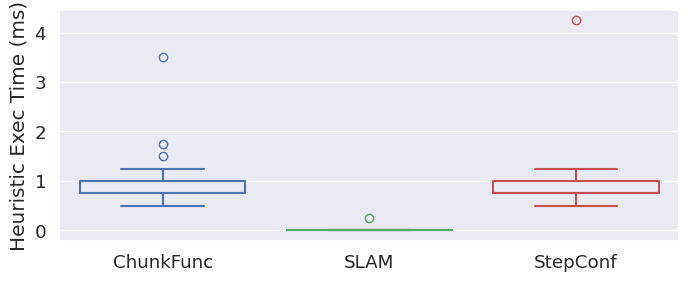

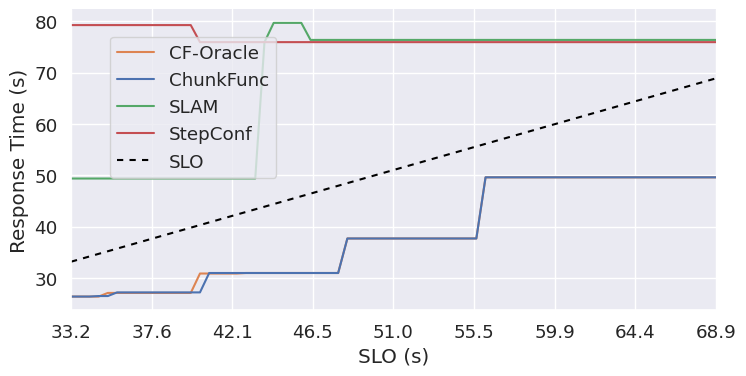

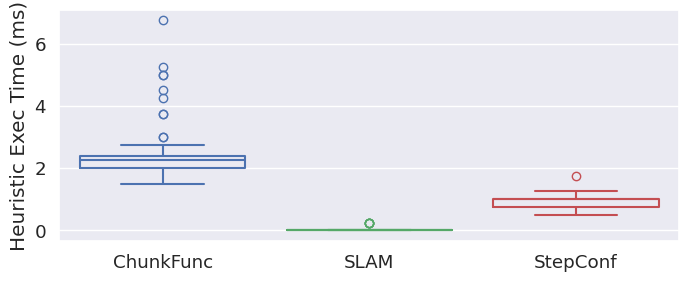

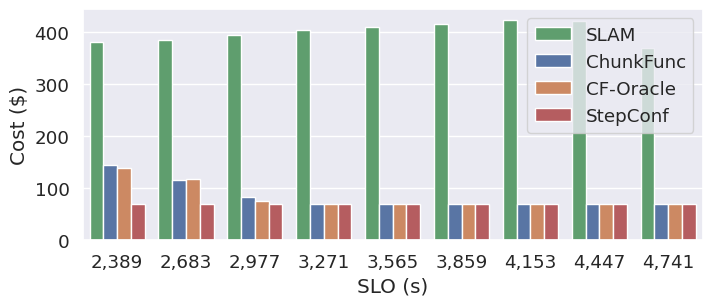

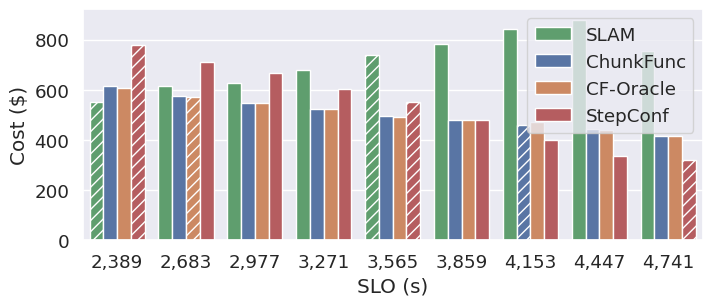

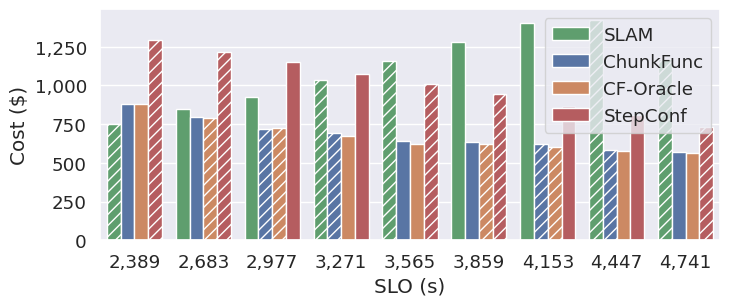

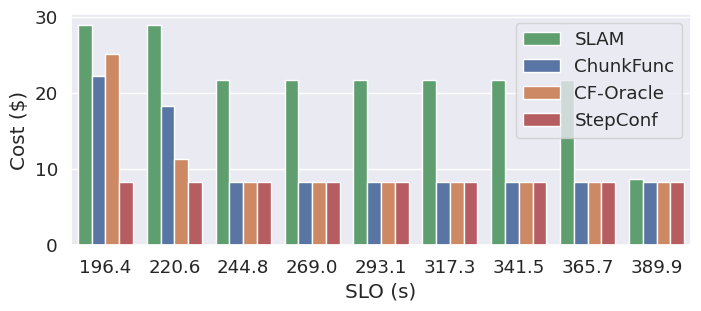

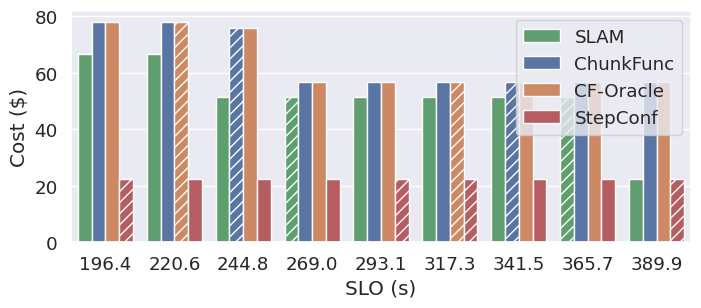

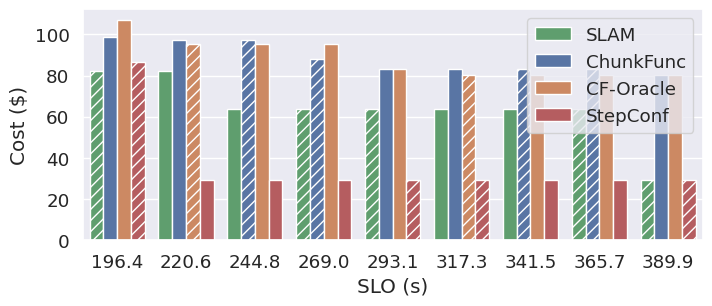

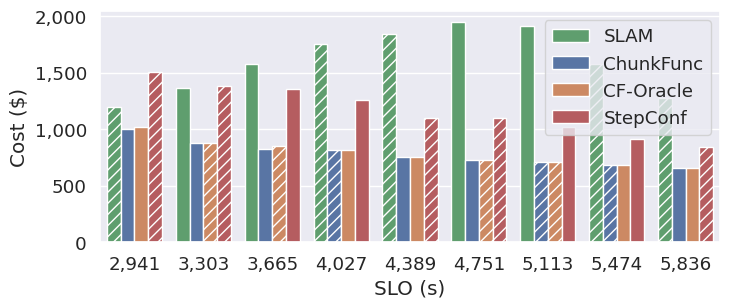

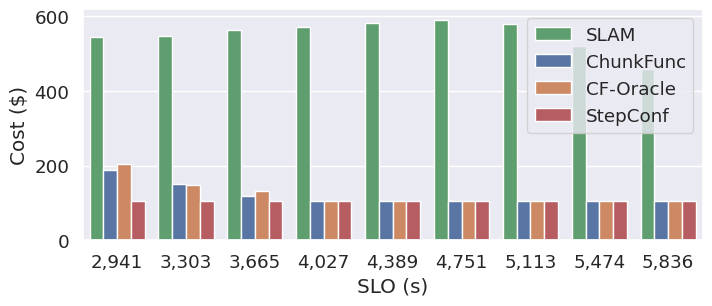

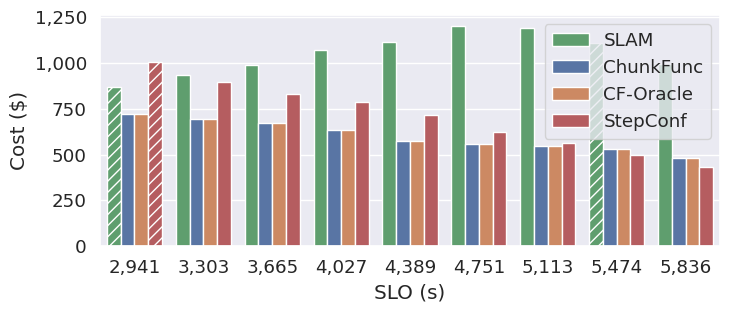

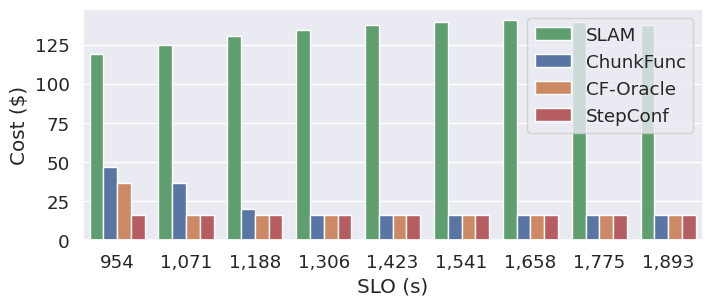

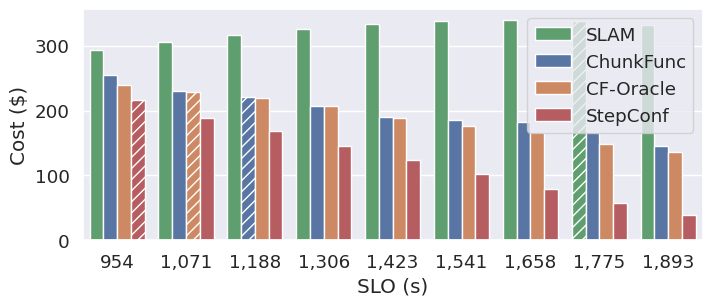

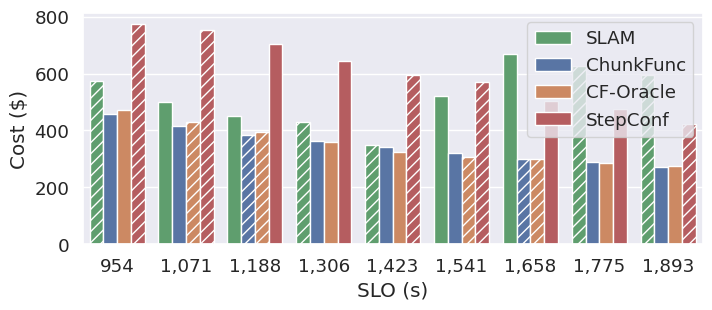

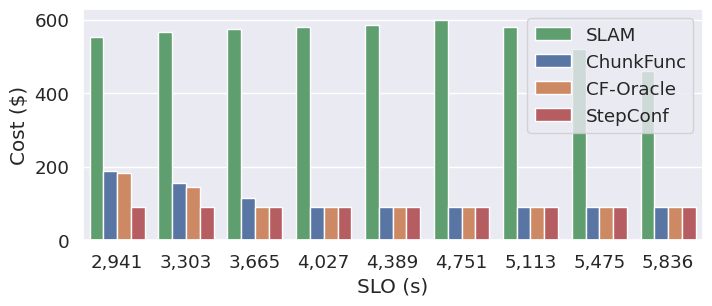

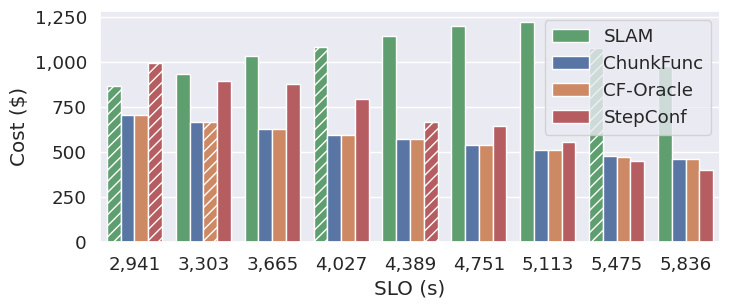

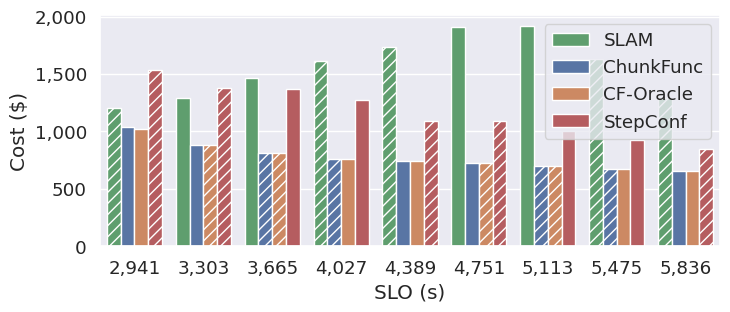

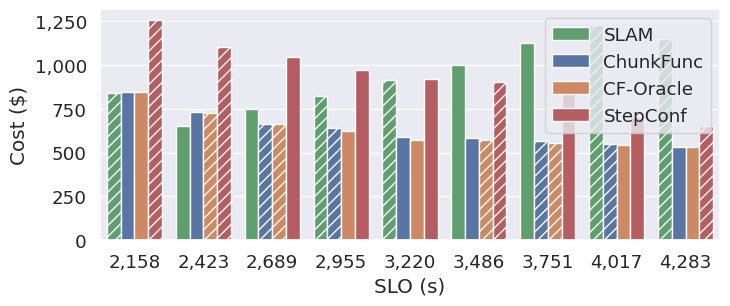

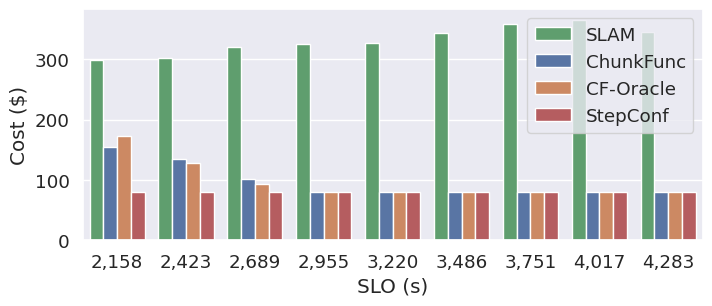

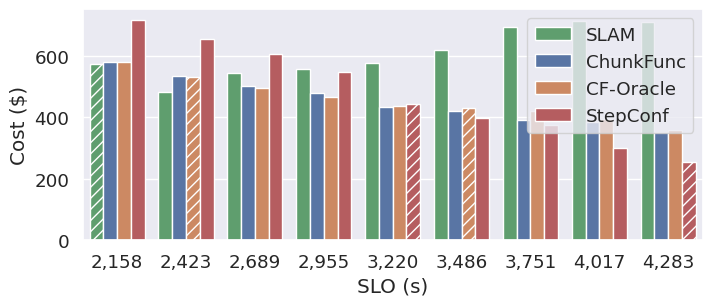

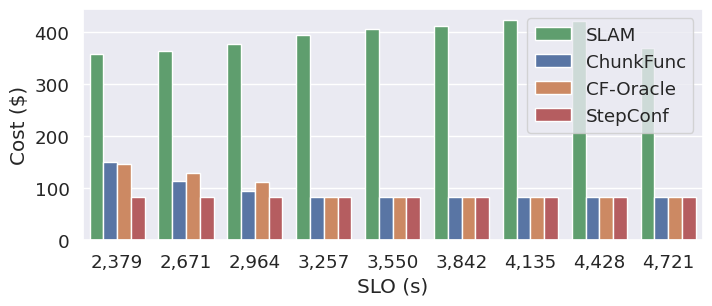

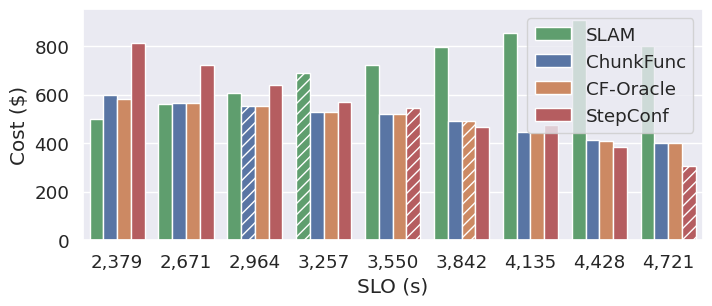

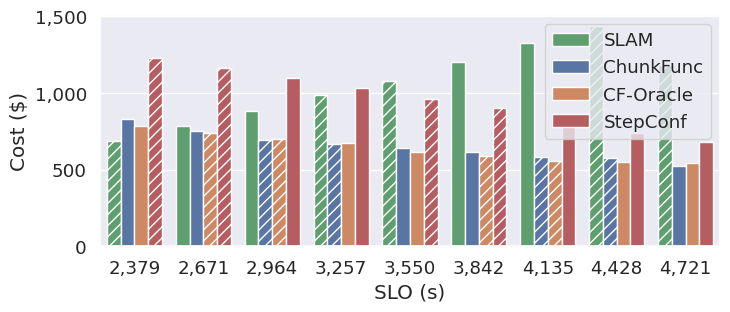

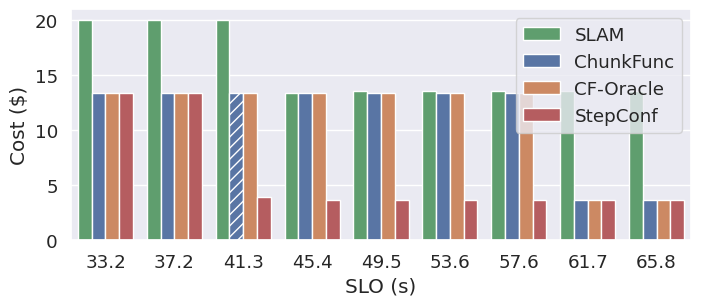

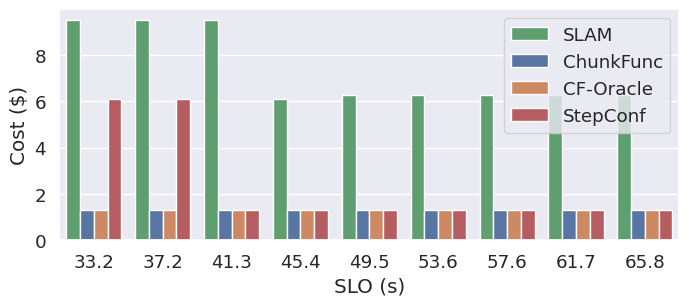

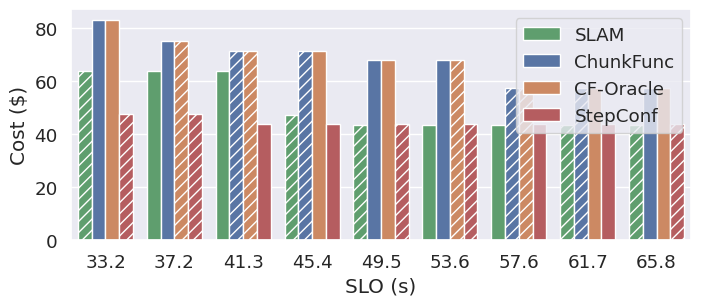

In [10]:
# SLO Compliance
slo_compliance_by_wf: list[dict[str, float | str]] = []
slo_compliance_by_wf_input: list[dict[str, float | str]] = []
for sim_result in simulation_results:
    total_slo_compliance: dict[str, float | str] = { strat: 0.0 for strat in strategies.values() }

    for input_size in sim_result.df_grouped.groups.keys():
        df = sim_result.df_grouped.get_group(input_size)
        df_slo = add_slo_as_strategy(df)
        plot_slo_compliance(df_slo, f'{sim_result.name}-{input_size}')
        plot_alg_exec_time(df, f'{sim_result.name}-{input_size}')

        slo_compliance = compute_slo_compliance(df_slo)
        for strat, slo_comp_percent in slo_compliance.items():
            total_slo_compliance[strat] += slo_comp_percent
        slo_compliance[col_workflow] = f'{sim_result.name}-{input_size}'
        slo_compliance_by_wf_input.append(slo_compliance)
    
    # Aggregate the SLO compliances for all input sizes.
    input_sizes = len(sim_result.df_grouped.groups)
    for strat in total_slo_compliance.keys():
        total_slo_compliance[strat] /= input_sizes
    total_slo_compliance[col_workflow] = sim_result.name
    slo_compliance_by_wf.append(total_slo_compliance)

df_slo_compliance_by_wf = pd.DataFrame.from_records(data=slo_compliance_by_wf, index=col_workflow)
df_slo_compliance_by_wf.to_csv(f'{output_folder}/slo-compliance-by-workflow.csv')
df_slo_compliance_by_wf_input = pd.DataFrame.from_records(data=slo_compliance_by_wf_input, index=col_workflow)
df_slo_compliance_by_wf_input.to_csv(f'{output_folder}/slo-compliance-by-workflow-input.csv')


# Costs
costs: list[dict[str, float | str]] = []
for sim_result in simulation_results:
    for input_size in sim_result.df_grouped.groups.keys():
        df = sim_result.df_grouped.get_group(input_size)
        df_cost = select_costs_for_plotting(df, 9)
        plot_costs(df_cost, f'{sim_result.name}-{input_size}')
    
    workflow_costs: dict[str, float | str] = compute_cost_when_slo_compliant(sim_result)
    workflow_costs[col_workflow] = sim_result.name
    costs.append(workflow_costs)

df_costs = pd.DataFrame.from_records(data=costs, index=col_workflow)
df_costs.to_csv(f'{output_folder}/slo-compliant-costs.csv')